<a href="https://colab.research.google.com/github/ManelGH1167/MasterIA/blob/main/Actividad_C1_Manel_Gonzalez_Huete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Actividad Proyecto Práctico - Convocatoria 1**

## 0) Lectura de datos

In [ ]:
# Importar las librerías:
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import binary_fill_holes
from google.colab import drive

try:
    import cv2
except ImportError:
    print("opencv no está instalado. Instalando ahora...")
    !pip install opencv-python

    import cv2

try:
    from skimage.morphology import remove_small_objects
except ImportError:
    print("skimage no está instalada. Instalando ahora...")
    !pip install scikit-image

    from skimage.morphology import remove_small_objects

In [10]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


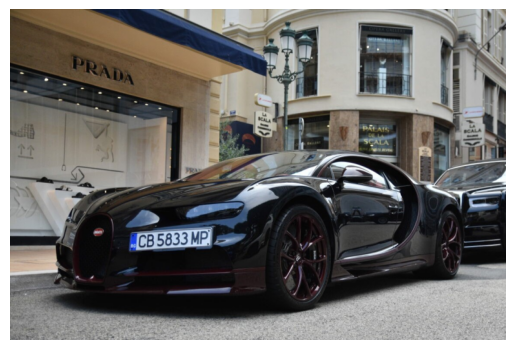

In [22]:
# Cargar la imagen 'auto_1.jpg' con opencv
BASE_PATH = '/content/drive/My Drive/Colab Notebooks/'
img_path = BASE_PATH+'images/auto_1.jpg'
img = cv2.imread(img_path)

# Verificar si la imagen se cargó correctamente
if img is None:
    print(f"Error: No se pudo cargar la imagen desde la ruta: {img_path}")
# La imagen se cargó correctamente
else:
    # Convertir la imagen a formato RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Redimensionar la imagen mediante el método de opencv "resize()" a un tamaño de (768,512)
    img_resize = cv2.resize(img_rgb, (768,512), interpolation=cv2.INTER_AREA)

    # Visualizar la imagen
    plt.imshow(img_resize)
    plt.axis('off')  # Ocultar los ejes
    plt.show()


## 1) Detección de bordes con Canny

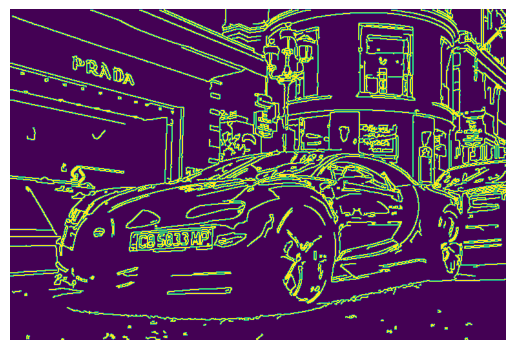

In [ ]:
# Aplicar un filtro gaussiano con un kernel de 3x3
kernel_size = (3, 3)
img_gaussian = cv2.GaussianBlur(img_resize, kernel_size, sigmaX=0)

# Aplicar el método de Canny para la detección de bordes
# Probando con las imagenes "auto_x", los limites que mejor funcionaban eran los siguientes:
min_threshold = 80  # Umbral inferior
max_threshold = 160  # Umbral superior
img_edge = cv2.Canny(img_gaussian, min_threshold, max_threshold)

# Aplicar una dilatación con un kernel de 2x2 y 1 iteración
kernel = np.ones((2, 2))
# Aplicar la dilatación con 1 iteración
img_edge_expand = cv2.dilate(img_edge, kernel, iterations=1)

# Visualizar la máscara resultante
plt.imshow(img_edge_expand)
plt.axis('off')  # Ocultar los ejes
plt.show()

## 2) Procesamiento mediante operaciones morfológicas

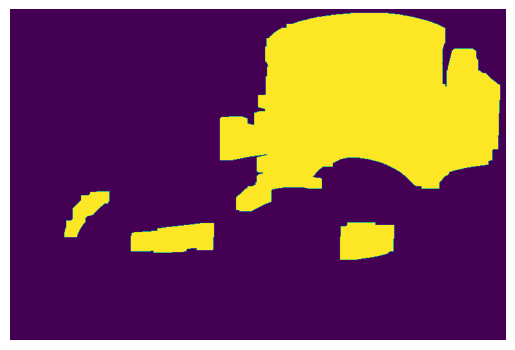

In [ ]:
# Nos aseguramos de convertir la imagen al formato uint8
img_edge_expand_uint8 = img_edge_expand.astype(np.uint8)

# Aplicar el comando "binary_fill_holes" sobre los bordes detectados, para rellenar los agujeros en la imagen
# Nota: convertir la imagen a formato "uint8"
img_edge_fill = binary_fill_holes(img_edge_expand_uint8).astype(np.uint8)

# Aplicar una apertura en el eje vertical con un kernel de 20x1 y 1 iteración para eliminar bordes verticales.
# Nota: Aplicar el método de opencv "mophologyEx()" con cv2.MORPH_OPEN.
kernel_open_vert = np.ones((20, 1), np.uint8)  # Kernel de 20x1
img_edge_open = cv2.morphologyEx(img_edge_fill, cv2.MORPH_OPEN, kernel_open_vert)

# Aplicar una apertura en el eje horizontal con un kernel de 1x20 y 1 iteración para eliminar bordes horizontales
kernel_open_horz = np.ones((1, 20), np.uint8)  # Kernel de 1x20
img_edge_open = cv2.morphologyEx(img_edge_open, cv2.MORPH_OPEN, kernel_open_horz)

# Eliminar artefactos, es decir, objetos cuya área tenga menos de 1000 píxeles con una connectivity=8.
# Nota: utilizar el método "remove_small_objects()" sobre la máscara anterior en formato booleano.
# Primero convertimos la imagen a formato booleano para eliminar artefactos
img_edge_open_boolean = img_edge_open > 0

# Eliminar objetos pequeños con un área menor a 1000 píxeles (usando conectividad=8)
img_edge_clean = remove_small_objects(img_edge_open_boolean, min_size=1000, connectivity=8)

# Convertir la máscara resultante a formato uint8
img_edge_clean = (img_edge_clean).astype(np.uint8)

# Visualizar la máscara resultante
plt.imshow(img_edge_clean)
plt.axis('off')  # Ocultar los ejes
plt.show()


## 3) Detección automática de la región de interés correspondiente a la matrícula

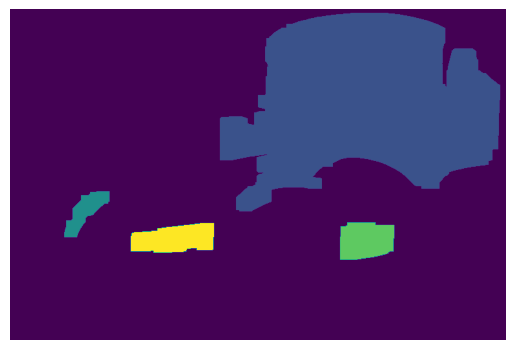

Cálculo de las proporciones (minor_axis_length / major_axis_length) para cada objeto:
Objeto 1: 0.6397
Objeto 2: 0.3275
Objeto 3: 0.6473
Objeto 4: 0.2998


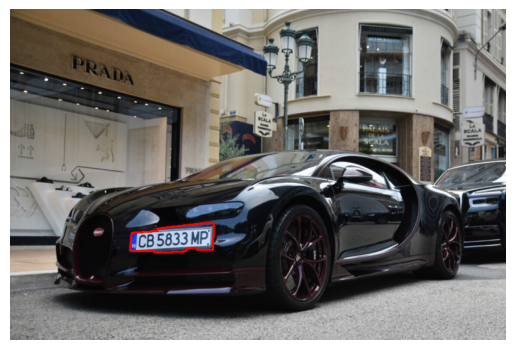

In [ ]:
from skimage.measure import label
from skimage.measure import regionprops

# Crear una imagen de etiquetas mediante el comando "label"
img_label = label(img_edge_clean)
# Visualizar la máscara resultante
plt.imshow(img_label)
plt.axis('off')  # Ocultar los ejes
plt.show()

# Calcular la proporción (cociente) entre el minor_axis_length y el major_axis_length para cada objeto de la imagen de etiquetas
properties = regionprops(img_label)
# Lista para guardar las proporciones (cocientes)
proportions = []

# Iterar sobre cada objeto y calcular la proporción entre el minor_axis_length y el major_axis_length
for reg in properties:
    minor_axis = reg.minor_axis_length  # Longitud del eje menor
    major_axis = reg.major_axis_length  # Longitud del eje mayor

    # Calcular la proporción (cociente)
    if major_axis != 0:  # Para evitar la división por cero
        proportion = minor_axis / major_axis
    else:
        proportion = 0  # Si el eje major_axis es cero, asignamos proporción a cero

    # Guardamos las diferentes proporciones
    proportions.append(proportion)

# Mostrar las proporciones y buscamos el objeto de menor proporción
min_index = -1
min_proportion = float('inf')  # Inicializamos con un valor muy grande
print("Cálculo de las proporciones (minor_axis_length / major_axis_length) para cada objeto:")
for i, proportion in enumerate(proportions):
    print(f"Objeto {i + 1}: {proportion:.4f}")
    # buscamos la proporción menor para encontrar su índice.
    if proportion < min_proportion:
        min_proportion = proportion
        min_index = i

# Generar una máscara que contenga únicamente el objeto de la menor proporción.
# Inicializamos una máscara vacía (toda en 0)
min_mask = np.zeros_like(img_label, dtype=np.uint8)

# Generamos la máscara del objeto con la menor proporción
min_mask[img_label == (min_index + 1)] = 255  # Asignamos valor 255 para marcar el objeto

# Dibujar los contornos de la máscara sobre la imagen original y visualizar el resultado
# Primero buscamos los bordes de la imagen mascara con la menor proporción
edges, _ = cv2.findContours(min_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Dibujar los contornos de la máscara sobre la imagen original
img_edge_plate = img_resize.copy()  # Hacemos una copia de la imagen original
# Dibujar los contornos con color (por ejemplo, en rojo)
cv2.drawContours(img_edge_plate, edges, -1, (255, 0, 0), 2)  # Color rojo y grosor de 2 píxeles

# Visualizar la imagen resultante
plt.imshow(img_edge_plate)
plt.axis('off')  # Ocultar los ejes
plt.show()

## 4) Procesamiento de la región de interés

Orientación de la máscara de bordes: -5.49 grados


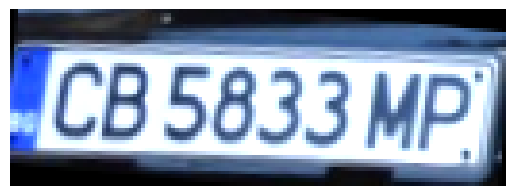

In [ ]:
import math

# Calcular las variables de la boundingbox de la máscara
x, y, w, h = cv2.boundingRect(edges[0])  # Solo se toma el primer contorno

# Hacer un crop de la imagen original a partir de las coordenadas de la boundingbox
img_crop = img_resize[y:y + h, x:x + w]

# Calcular la orientación de la máscara.
mask_prop = regionprops(min_mask)
# Convertir la orientación de radianes a grados
edges_orientation = mask_prop[0].orientation

# Hacer una conversión mediante la siguiente fórmula:
    # angle = (orientation*90)/(math.pi/2). Nota: utilizar "import math"
    # Si 'angle' es mayor que 0, la orientación será igual a 90-angle
    # Si no, la orientación será igual a -(90+angle)
angle = (mask_prop[0].orientation*90)/(math.pi/2)
if (angle>0):
    edges_orientation = 90 - angle
else:
    edges_orientation = -(90 + angle)

print(f"Orientación de la máscara de bordes: {edges_orientation:.2f} grados")

# Aplicar una transformación geométrica de rotación para orientar horizontalmente el crop de la imagen obtenido anteriormente
(h, w) = img_crop.shape[:2] # Obtener las dimensiones de la imagen del crop
center = (w // 2, h // 2) # Calcular el centro de la imagen del crop

# Crear la matriz de rotación
rotation_matrix = cv2.getRotationMatrix2D(center, edges_orientation, 1.0)
# Rotar la imagen
img_rotated_crop = cv2.warpAffine(img_crop, rotation_matrix, (w, h))

# Aumentar el contraste 100 unidades de acuerdo a la fórmula vista en clase.
contrast_factor = 1.0 + (100 / 255)  # 100 unidades de aumento de contraste
brightness_offset = 0  # No se modifica el brillo
# Aumentar el contraste
img_contrast = cv2.convertScaleAbs(img_rotated_crop, alpha=contrast_factor, beta=brightness_offset)

# Visualizar el resultado la matrícula con el contraste aumentado
plt.imshow(img_contrast)
plt.axis('off')  # Ocultar los ejes
plt.show()

## 5) Convertir el contenido de la imagen en un string mediante la librería 'pytesseract'
Para instalar la librería pytesseract:
    
    Descargar el ejecutable en -->  https://github.com/UB-Mannheim/tesseract/wiki
    Instalar la librería haciendo --> pip install pytesseract

Si se tienen dudas, consultar el siguiente vídeo:

    https://www.youtube.com/watch?v=_j6o2rBkhhg

In [ ]:
try:
    import pytesseract
except ImportError:
    print("pytesseract no está instalada. Instalando ahora...")
    !pip install pytesseract

    import pytesseract

La matricula es: CB5833MP 


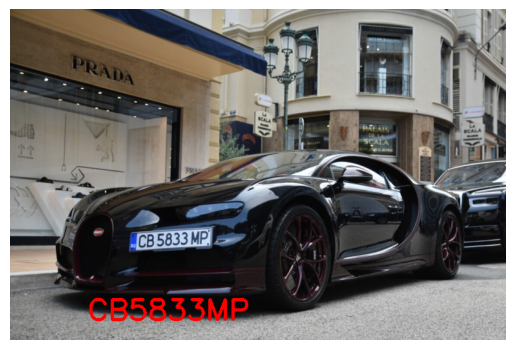

In [ ]:
# Crear la ruta de pytesseract que contenga el ejecutable
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Convertir el contenido de la imagen en una variable de tipo string.
# Importante: utiliza la opción --> config='--psm 10'
img_text = pytesseract.image_to_string(img_contrast, config='--psm 10')

# Eliminar del string los caracteres especiales mediante la siguiente línea de código:
string = ''.join(filter(str.isalnum, img_text))
print(f"La matricula es: {string} ")

# Visualizar la imagen original y ponle el título extraído automáticamente mediante la librería "pytesseract"
# Configuración del texto: posición (50,50), color (0, 0, 0) (blanco), tamaño 1 y grosor 2
cv2.putText(img_resize, string, (120, 480), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)

plt.imshow(img_resize)
plt.axis('off')  # Ocultar los ejes
plt.show()
